In [1]:
"""
Code for BERT
"""
import torch
from torch import nn

In [2]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [64]:
import math
import collections
from typing import Union, Optional

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
        
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis.

    Defined in :numref:`sec_attention-scoring-functions`"""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    """Scaled dot product attention.

    Defined in :numref:`subsec_batch_dot`"""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class MultiHeadAttention(nn.Module):
    """Multi-head attention.

    Defined in :numref:`sec_multihead-attention`"""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads.
    
        Defined in :numref:`sec_multihead-attention`"""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv.
    
        Defined in :numref:`sec_multihead-attention`"""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network.

    Defined in :numref:`sec_transformer`"""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class AddNorm(nn.Module):
    """The residual connection followed by layer normalization.

    Defined in :numref:`subsec_positionwise-ffn`"""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
        
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block.

    Defined in :numref:`subsec_positionwise-ffn`"""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
        
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [11]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)

In [13]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
tokens.shape, segments.shape, encoded_X.shape

(torch.Size([2, 8]), torch.Size([2, 8]), torch.Size([2, 8, 768]))

In [14]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [15]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [16]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [17]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [18]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1) # !! here it use all the sequnce, but in training we just use [cls]
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
encoded_X.shape, nsp_Y_hat.shape

(torch.Size([2, 6144]), torch.Size([2, 2]))

In [19]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [47]:
import random
import os
"""
This dataset every line is a paragraph, every punctuation is added a whitespace around.
"""
def _read_wiki(data_dir:str) -> list[list[str]]:
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [48]:
wiki = _read_wiki("../../Data/wikitext-2/")

In [50]:
"""
Generate next sentence, half of them are negitive
"""

def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [67]:
"""
Generate MLM
"""

def _replace_mlm_tokens(
    tokens:list[str], 
    candidate_pred_positions:list[int], 
    num_mlm_preds:int,
    vocab:Vocab
) -> Union[list[str], list[Union[int, str]]]:
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens] # !!! make a copy !!!
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

def _get_mlm_data_from_tokens(
    tokens:list[str], 
    vocab:Vocab
) -> Union[list[int], list[int], list[int]]:
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

def _pad_bert_inputs(
    examples, 
    max_len:int, 
    vocab
):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [68]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_utils`"""
    assert token in ('word', 'char'), 'Unknown token type: ' + token
    return [line.split() if token == 'word' else list(line) for line in lines]

class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs:list[list[str]], max_len:int):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [tokenize(
            paragraph, token='word') for paragraph in paragraphs] # list[list[list[str]]]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph] # paragraph -> list[list[str]], sentence -> list[str], this -> list[list[str]]
        self.vocab = Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [69]:
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = 0
    data_dir = "../../Data/wikitext-2/"
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [70]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [72]:
paragraphs = [tokenize(
            paragraph, token='word') for paragraph in wiki]
print(paragraphs[0]) # paragraphs -> list[list[list[str]]], where paragraphs[0][0] is a list of token
# it is a sentence, so paragraphs[0] is a list of sentences -> paragraph.
sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph] # sentences -> list[list[str]], list of sentences
print(sentences[0])

[['the', 'right', '@-@', 'of', '@-@', 'way', 'along', 'm', '@-@', '6', 'includes', 'a', '9', '@-@', 'mile', '(', '14', 'km', ')', 'pedestrian', 'path', 'known', 'as', 'the', 'frederik', '<unk>', 'trail'], ['previously', 'called', 'the', 'm', '@-@', '6', 'trail', ',', 'it', 'links', 'the', 'kent', 'trails', 'west', 'of', 'byron', 'center', 'avenue', 'in', 'wyoming', 'with', 'the', 'paul', 'henry', 'rail', 'trail', 'at', '60th', 'street', 'and', 'wing', 'avenue', 'by', 'paris', 'park', 'in', 'kentwood', '.']]
['the', 'right', '@-@', 'of', '@-@', 'way', 'along', 'm', '@-@', '6', 'includes', 'a', '9', '@-@', 'mile', '(', '14', 'km', ')', 'pedestrian', 'path', 'known', 'as', 'the', 'frederik', '<unk>', 'trail']


In [96]:
net = BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = ['cuda']
loss = nn.CrossEntropyLoss()

In [75]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [93]:
import matplotlib.pyplot as plt
import time
from IPython import display
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        # use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # net = net.to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, Timer()
    animator = Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.352, NSP loss 0.733
8724.4 sentence pairs/sec on ['cuda']


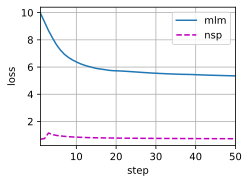

In [97]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [82]:
torch.save(net.state_dict(), "../../Data/bert.pth")

In [84]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [85]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-1.1969, -2.0704,  0.0704], device='cuda:0', grad_fn=<SliceBackward0>))

In [86]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.4943, -0.3056,  0.6085], device='cuda:0', grad_fn=<SliceBackward0>))